# Orthogonal Manifolds in Abstract Spaces
It's unclear whether we observed orthogonal manifolds only becase the rules mapped onto orthogonal dimensions in the input space. Aim of this little notebook is to test whether the same features would be observed if there was no structure in the inputs. To test this, we use n-hot encodings in the inputs, which are permutation invariant, i.e. don't carry any information about the spatial arrangement of stimuli.  
We then proceed with RSA on the hidden layer representations to probe for the existence of orthogonal manifolds

## import libraries

In [27]:
import torch
import torch.nn.functional as F
from torch import optim
from scipy.spatial.distance import squareform, pdist
import numpy as np
import matplotlib.pyplot as plt
from plot_utils import *
from sklearn.manifold import MDS
from more_itertools import distinct_permutations
import pickle

## set parameters

In [21]:
# define parameters 
# Neural Network
N_HIDDEN = 1000
SIGMA_IN_STIM = 1e-8
SIGMA_IN_CTX = 5e-1 #5e-1 # separate weight for context info
SIGMA_HIDDEN = 1/(N_HIDDEN**.5)
SIGMA_OUT = 1/(N_HIDDEN**.5)

# Optimisation
LRATE = 1e-2 #1e-2 # was 5e-2 for 1k hidden
N_ITER = 5000 # was 5k for 1k hidden
MONITOR_CMD = True # if true, print stats to command line\
MONITOR_ITERS = 1000 # print each x iters to cmd
num_runs = 10  #number of independent runs

## define auxiliary functions and the network architecture

### Data Generator

In [3]:
def mk_block(feature='dangerousness'):
    """
    generates single block of 25 trials 
    x: 25x12 (5 lvls of dangerousness, 5 lvls of size, 2 possible tasks)
    y: 25x1 (predicted value is continuous, 1 to 5)
    
    """
    
    d,s = np.meshgrid(np.arange(5),np.arange(5))
    d = d.flatten()
    s = s.flatten()
    x = np.zeros((25,12))

    for ii in range(len(d)):
        x[ii,d[ii]] = 1
        x[ii,s[ii]+5] = 1

    if feature=='dangerousness':
        y = d-np.mean(d) 
        x[:,10] = 1
    elif feature=='size':
        y = s-np.mean(s)
        x[:,11] = 1
    return x.astype(np.float32),y[:,np.newaxis].astype(np.float32)
    

def mk_experiment():
    # one block per task:
    x1,y1 = mk_block('dangerousness')
    x2,y2 = mk_block('size')
    x = np.concatenate((x1,x2),axis=0)
    y = np.concatenate((y1,y2),axis=0)
    #print(x.shape)
    # test data doesn't have to be shuffled
    x_test = x
    y_test = y
    
    # shuffle training data
    ii_shuff = np.random.permutation(50)
    x_train = x[ii_shuff,:]
    y_train = y[ii_shuff,]
    return x_train,y_train, x_test,y_test


#alternative function for generating random inputs
def mk_experiment_rand():
    rand_mat = np.random.choice([0,1], [25,25])
    Q, R = np.linalg.qr(rand_mat)
    x = Q.T
    x = np.concatenate([x,x])

    context_1 = np.concatenate([np.zeros(25), np.ones(25)])
    context_2 = np.concatenate([np.ones(25), np.zeros(25)])
    context_1 = context_1[:,np.newaxis]/5
    context_2 = context_2[:,np.newaxis]/5
    x = np.concatenate([x, context_1, context_2], axis=1)

    d,s = np.meshgrid(np.arange(5),np.arange(5))
    d = d.flatten()
    s = s.flatten()
    y_d= d-np.mean(d)
    y_s = s-np.mean(s)
    y = np.concatenate([y_d, y_s])
    y = y[:, np.newaxis]

    x = x.astype(np.float32)
    y = y.astype(np.float32)

    x_test = x
    y_test = y

    ii_shuff = np.random.permutation(50)
    x_train = x[ii_shuff,:]
    y_train = y[ii_shuff,]
    return x_train,y_train, x_test,y_test
    
    

### Neural Network 

In [29]:
class Nnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # input weights
        self.w_h1x = torch.nn.Parameter(torch.randn(25,N_HIDDEN)*SIGMA_IN_STIM)
        self.b_h1 = torch.nn.Parameter(torch.zeros(N_HIDDEN))        
        # context weights
        self.w_h1c = torch.nn.Parameter(torch.randn(2,N_HIDDEN)*SIGMA_IN_CTX)
        
        # hidden weights
        self.w_h2 = torch.nn.Parameter(torch.randn(N_HIDDEN,N_HIDDEN)*SIGMA_HIDDEN)
        self.b_h2 = torch.nn.Parameter(torch.zeros(N_HIDDEN))
        
        # output weights
        self.w_o = torch.nn.Parameter(torch.randn(N_HIDDEN,1)*SIGMA_OUT)
        self.b_o = torch.nn.Parameter(torch.zeros(1))
        
    def forward(self,x_in):
        self.x_h1 = x_in[:,:25] @ self.w_h1x + x_in[:,25:] @ self.w_h1c + self.b_h1
        self.y_h1 = F.relu(self.x_h1)
        self.x_h2 = self.y_h1 @ self.w_h2 + self.b_h2
        self.y_h2 = F.relu(self.x_h2)
        self.x_o = self.y_h2 @ self.w_o + self.b_o

        return self.x_o

    def get_activity(self,x_test):
        # return activity patterns etc 
        self.forward(x_test)               
        yh1 = self.y_h1.cpu().detach().numpy()
        yh2 = self.y_h2.cpu().detach().numpy()
        yo = self.x_o.cpu().detach().numpy()
        
        return yh1,yh2,yo

    def get_rdm(self,x_test):
        self.forward(x_test)
        rdm1 = squareform(pdist(self.y_h1.cpu().detach().numpy()))
        rdm2 = squareform(pdist(self.y_h2.cpu().detach().numpy()))
        return rdm1, rdm2


### Training Procedure and Model Evaluation

In [15]:
def loss_funct(y_,t):
    return torch.nn.functional.mse_loss(y_,t)

def accuracy(y_,t):
    return (torch.round(y_)==torch.round(t)).float().mean()

def get_model():
    model = Nnet()
    return model, optim.SGD(model.parameters(), lr=LRATE)

def fit(model, disp=False):
    """
    trains model
    """
    losses = []
    accs = []
    for ep in range(N_ITER):
        # train with full batch gradient descent
        y_ = model(x_train)
        loss = loss_funct(y_,y_train)
        acc = accuracy(y_,y_train)
        loss.backward()
        opt.step()
        opt.zero_grad()
        if ep%MONITOR_ITERS==0 and MONITOR_CMD:
            print("iteration {}, MSE {}, accuracy {}".format(ep,loss,acc))
        losses.append(loss)
        accs.append(acc)
    if disp==True:
        disp_performance(losses,accs,'Training')
    return losses, accs

def choicemat(x,model):
    _,_,yo = model.get_activity(x)
    mat1 = yo[:25,:].reshape((5,5))
    mat2 = yo[25:,:].reshape((5,5))
    return mat1,mat2

def evaluate(x_test,y_test,model):
    """
    evaluates model, returning "test" accuracy and hidden layer responses
    """
    # test accuracy
    acc1,acc2 = taskaccuracy(x_test,y_test,model)
    
    # choice matrices 
    mat1,mat2 = choicemat(x_test,model)
    
    # hidden layer RDM 
    rdm1,rdm2 = model.get_rdm(x_test)
    
    return acc1,acc2,mat1,mat2,rdm1,rdm2
def save_data(fn):
    with open('./results/' + fn,'wb') as f:    
        pickle.dump([acc1s, acc2s, mat1s, mat2s, rdmsh1, rdmsh2], f)

In [ ]:
save_data('2cxt_nhot')

### Visualisation

In [6]:
# visualisation
def disp_performance(losses,accs,phase='Training'):
    plt.figure(figsize=(5,3))
    plt.subplot(1,2,1)
    plt.plot(losses)
    plt.xlabel('Iter')
    plt.ylabel('MSE')
    plt.title( phase + ' Loss')
    plt.subplot(1,2,2)
    plt.plot(accs)
    plt.xlabel('Iter')
    ax = plt.gca()    
    ticks = plt.yticks()[0]
    plt.yticks(ticks=ticks,labels=np.round(ticks*100))
    plt.ylabel('Acc (%)')
    plt.title(phase + ' Accuracy')
    plt.xlabel('Iter')
    plt.ylim([0,1.01])
    plt.tight_layout()

In [ ]:
# quick sanity checks
%matplotlib notebook
x,y,xt,yt = mk_experiment()
plt.figure(figsize=(8,3));
plt.subplot(1,2,1)
plt.imshow(x)
plt.title('training data')
plt.xlabel('features')
plt.ylabel('trials')
plt.subplot(1,2,2)
plt.imshow(xt)
plt.title('test data')
plt.xlabel('features')
plt.ylabel('trials')
plt.tight_layout()
xt.dtype

### Stats

In [7]:
# compute accuracy for each task
def taskaccuracy(x,y,model):    
    yo = model(x)
    #print(yo[:25,:].shape)
    #print(y[:25,:].shape)
    # 1st task
    acc1 = accuracy(yo[:25,:],y[:25,:]).detach().numpy()
    acc2 = accuracy(yo[25:,:],y[25:,:]).detach().numpy()
    return acc1,acc2
   
def choicemat(x,model):
    _,_,yo = model.get_activity(x)
    mat1 = yo[:25,:].reshape((5,5))
    mat2 = yo[25:,:].reshape((5,5))
    return mat1,mat2


## Train model and get stats for eval

In [30]:
acc1s = []
acc2s = []
mat1s = []
mat2s = []
rdmsh1 = []
rdmsh2 = []

for i in range(num_runs):
    print('run {}/{}....'.format(str(i+1),str(num_runs)))
    # get data
    x_train,y_train,x_test,y_test = map(torch.tensor, mk_experiment_rand())
    # # instantiate model
    nnet, opt = get_model()
    # # train on task
    l,a = fit(nnet,disp=False)

    # run this to get the data for the analysis section below
    acc1,acc2,mat1,mat2,rdm1,rdm2 = evaluate(x_test,y_test,nnet)
    acc1s.append(acc1)
    acc2s.append(acc2)
    mat1s.append(mat1)
    mat2s.append(mat2)
    rdmsh1.append(rdm1)
    rdmsh2.append(rdm2)
    
acc1s = np.array(acc1s)
acc2s = np.array(acc2s)
mat1s = np.array(mat1s)
mat2s = np.array(mat2s)
rdmsh1 = np.array(rdmsh1)
rdmsh2 = np.array(rdmsh2)


run 1/10....
iteration 0, MSE 2.000758409500122, accuracy 0.20000000298023224
iteration 1000, MSE 0.0007225360022857785, accuracy 1.0
iteration 2000, MSE 8.043542010227611e-08, accuracy 1.0
iteration 3000, MSE 6.162763355188616e-11, accuracy 1.0
iteration 4000, MSE 1.510698857676296e-11, accuracy 1.0
run 2/10....
iteration 0, MSE 2.001858949661255, accuracy 0.20000000298023224
iteration 1000, MSE 0.0009943986078724265, accuracy 1.0
iteration 2000, MSE 1.6550973214179976e-07, accuracy 1.0
iteration 3000, MSE 1.1689396672842634e-10, accuracy 1.0
iteration 4000, MSE 1.799930170187647e-11, accuracy 1.0
run 3/10....
iteration 0, MSE 2.0051608085632324, accuracy 0.20000000298023224
iteration 1000, MSE 0.0005870862514711916, accuracy 1.0
iteration 2000, MSE 1.2887768718883308e-07, accuracy 1.0
iteration 3000, MSE 1.1090640211763869e-10, accuracy 1.0
iteration 4000, MSE 1.4844800735880348e-11, accuracy 1.0
run 4/10....
iteration 0, MSE 2.0000429153442383, accuracy 0.20000000298023224
iteration

In [33]:
save_data('2ctxt_randortho')

## Statistical Analysis
1. Test Accuracy
2. Choice Matrices 
3. MDS on Hidden Layer
4. Model RSA on Hidden Layer

In [17]:
# Test Accuracy
for i in range(num_runs):
    print(" Accuracy run: {} Dangerousness Task: {}, Size Task: {}".format(i,acc1,acc2))

 Accuracy run: 0 Dangerousness Task: 1.0, Size Task: 1.0
 Accuracy run: 1 Dangerousness Task: 1.0, Size Task: 1.0
 Accuracy run: 2 Dangerousness Task: 1.0, Size Task: 1.0
 Accuracy run: 3 Dangerousness Task: 1.0, Size Task: 1.0
 Accuracy run: 4 Dangerousness Task: 1.0, Size Task: 1.0
 Accuracy run: 5 Dangerousness Task: 1.0, Size Task: 1.0
 Accuracy run: 6 Dangerousness Task: 1.0, Size Task: 1.0
 Accuracy run: 7 Dangerousness Task: 1.0, Size Task: 1.0
 Accuracy run: 8 Dangerousness Task: 1.0, Size Task: 1.0
 Accuracy run: 9 Dangerousness Task: 1.0, Size Task: 1.0


<IPython.core.display.Javascript object>


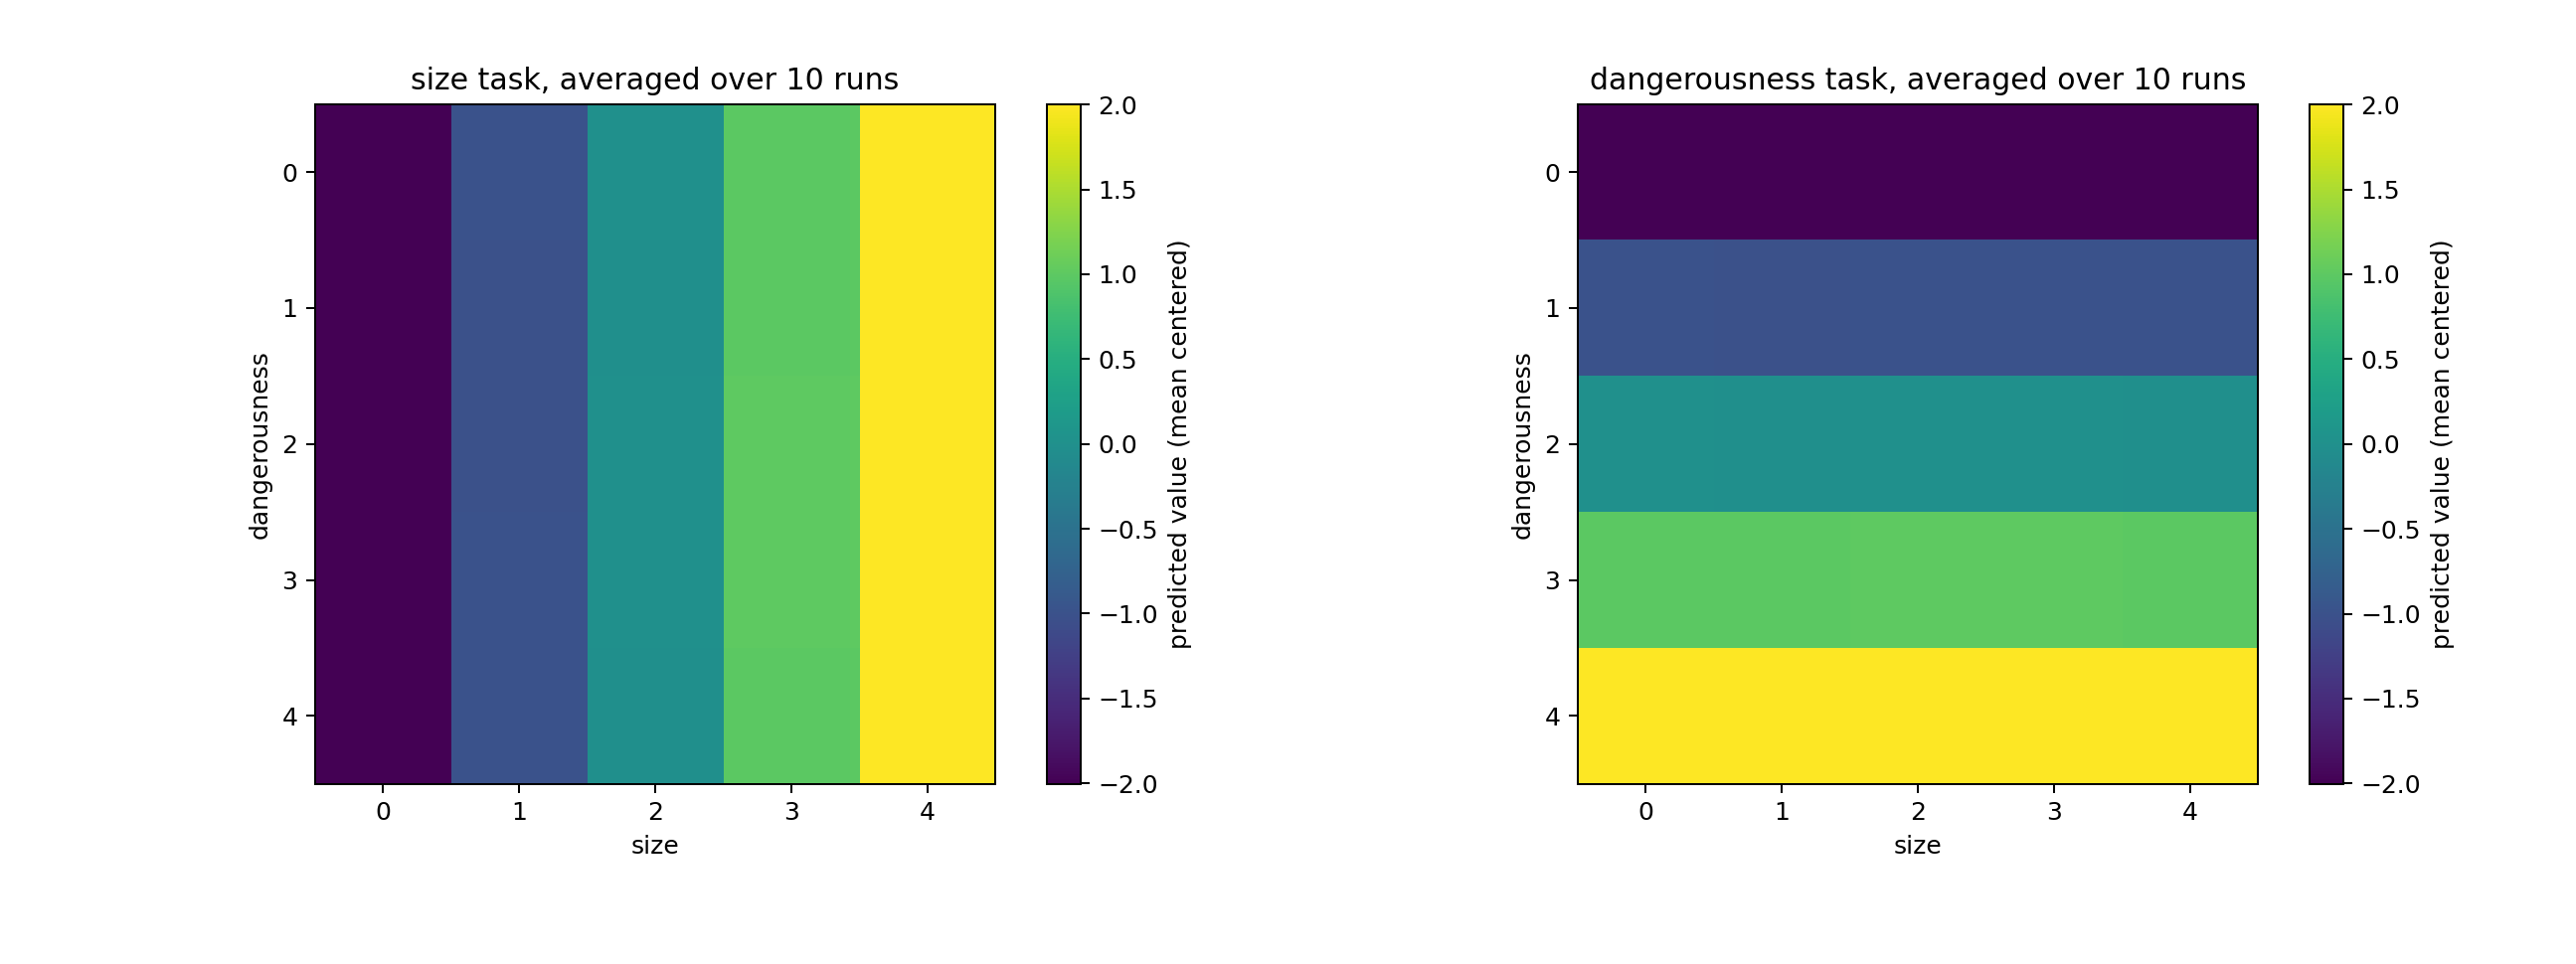

In [18]:
# Choice Matrices

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(np.mean(mat1s,0))
plt.xlabel('size')
plt.ylabel('dangerousness')
plt.title('size task, averaged over {} runs'.format(num_runs))
plt.colorbar(label='predicted value (mean centered)')
plt.subplot(1,2,2)
plt.imshow(np.mean(mat2s,0))
plt.xlabel('size')
plt.ylabel('dangerousness')
plt.title('dangerousness task, averaged over {} runs'.format(num_runs))
plt.colorbar(label='predicted value (mean centered)')
plt.tight_layout()

<IPython.core.display.Javascript object>


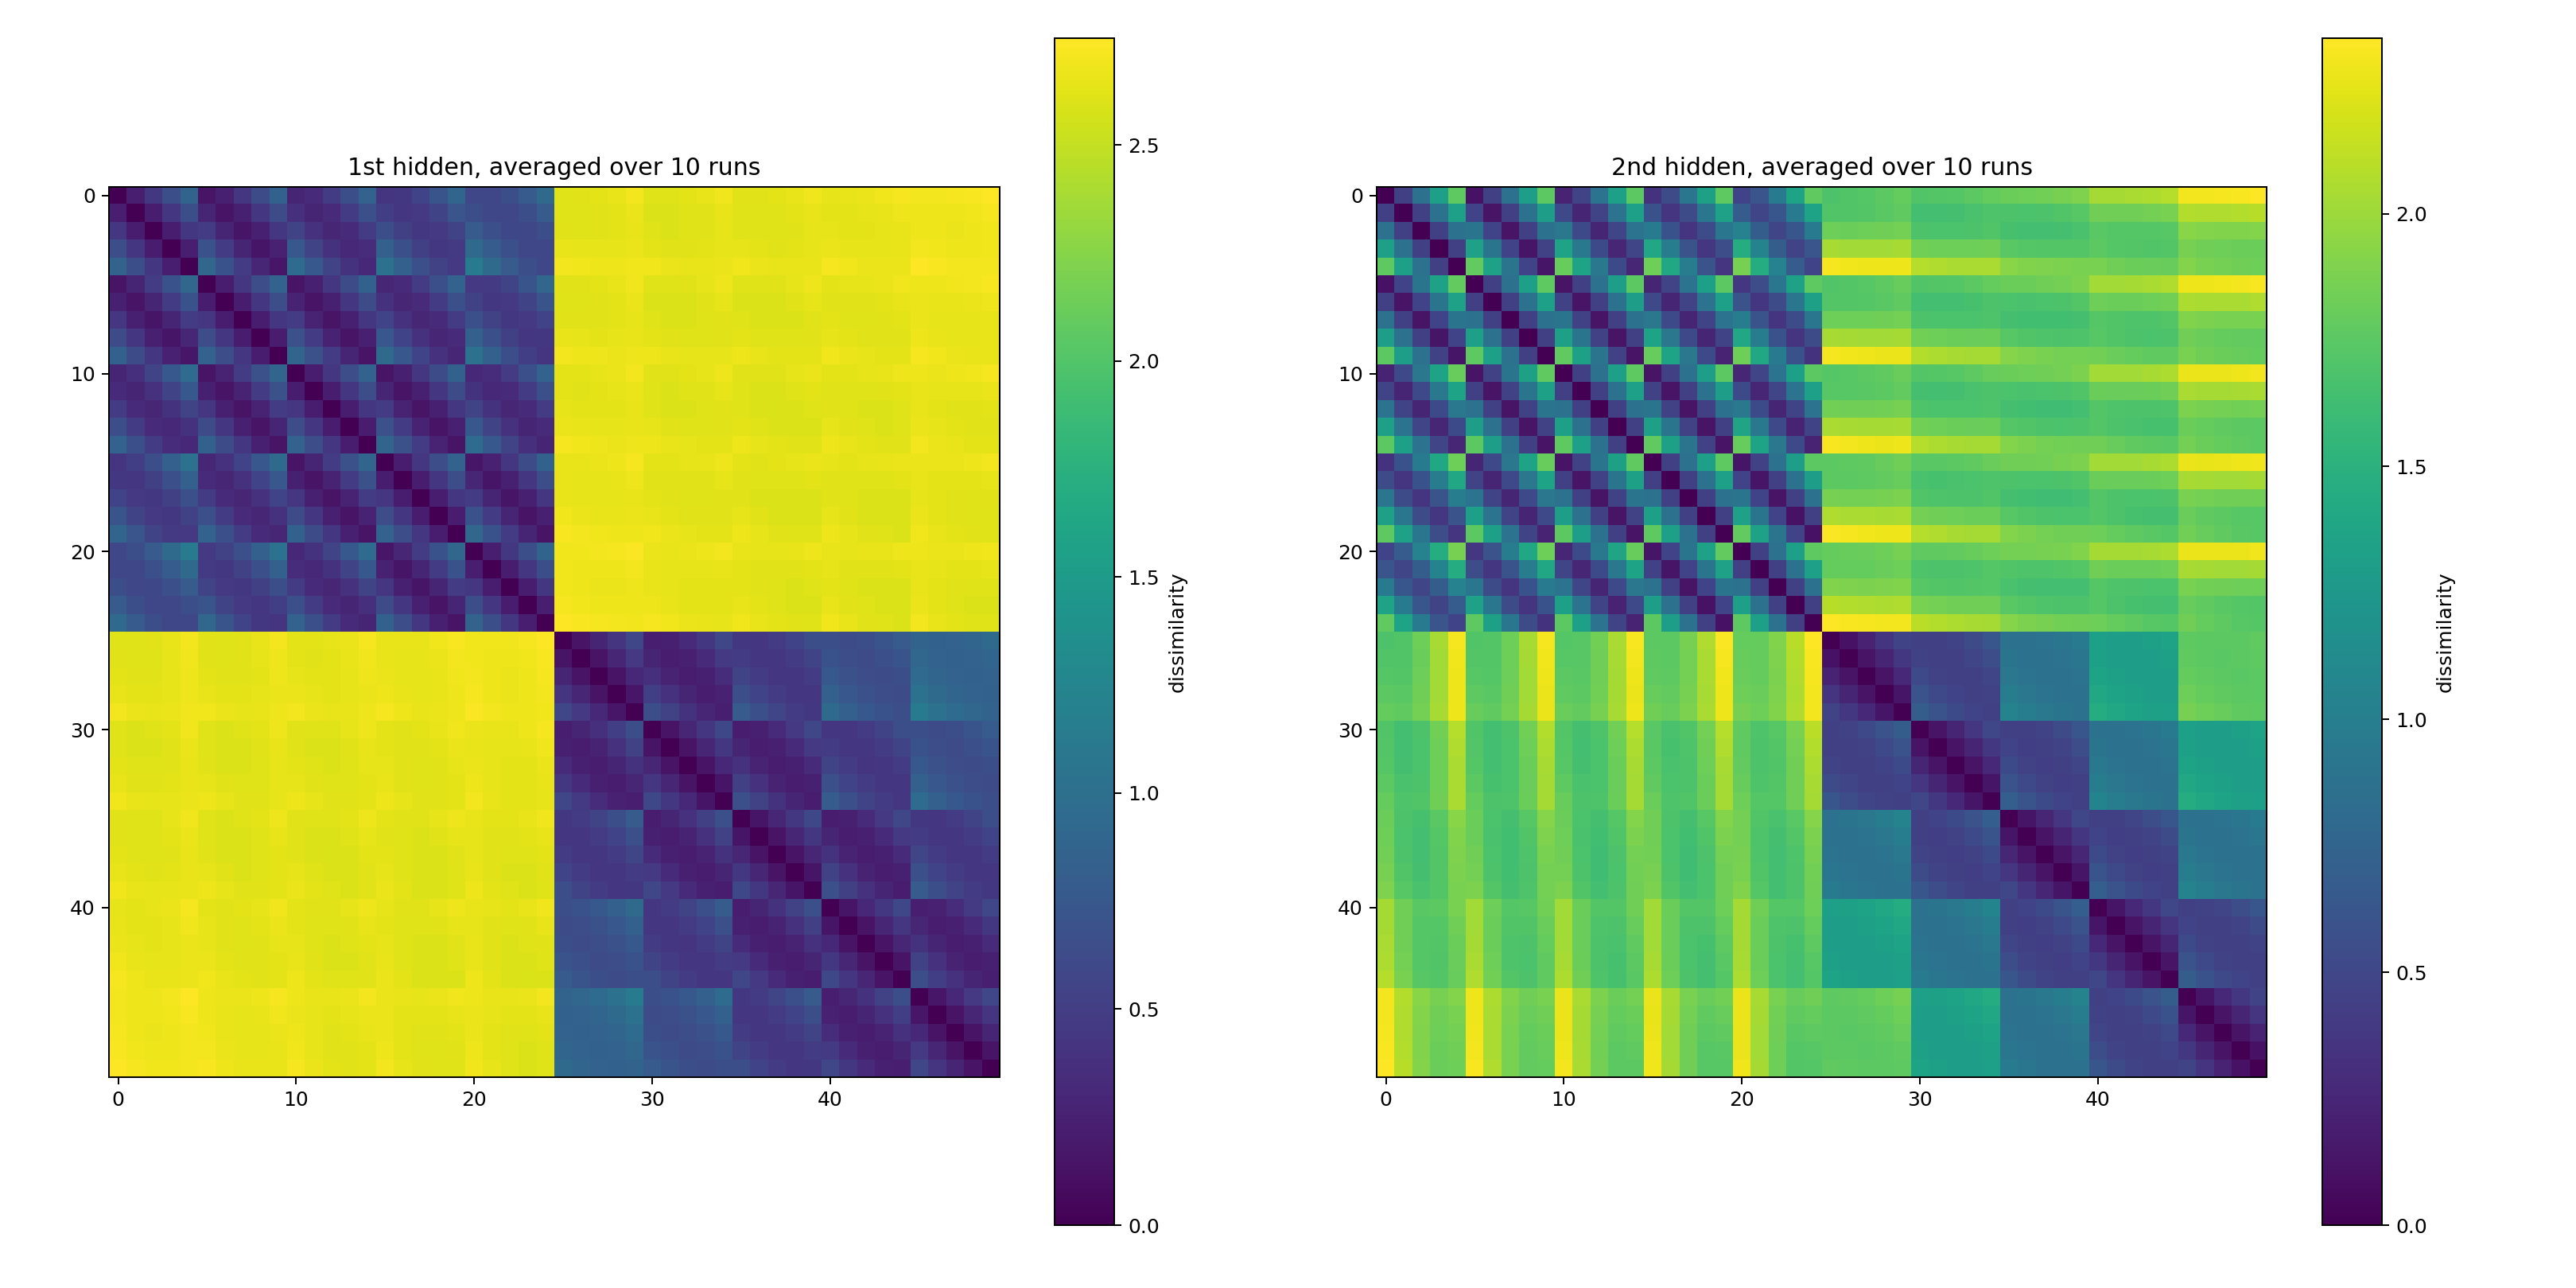

In [31]:
# RDM 

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.mean(rdmsh1,0))
plt.colorbar(label='dissimilarity')
plt.title('1st hidden, averaged over {} runs'.format(num_runs))
plt.subplot(1,2,2)
plt.imshow(np.mean(rdmsh2,0))
plt.colorbar(label='dissimilarity')
plt.title('2nd hidden, averaged over {} runs'.format(num_runs))
plt.tight_layout()

<IPython.core.display.Javascript object>


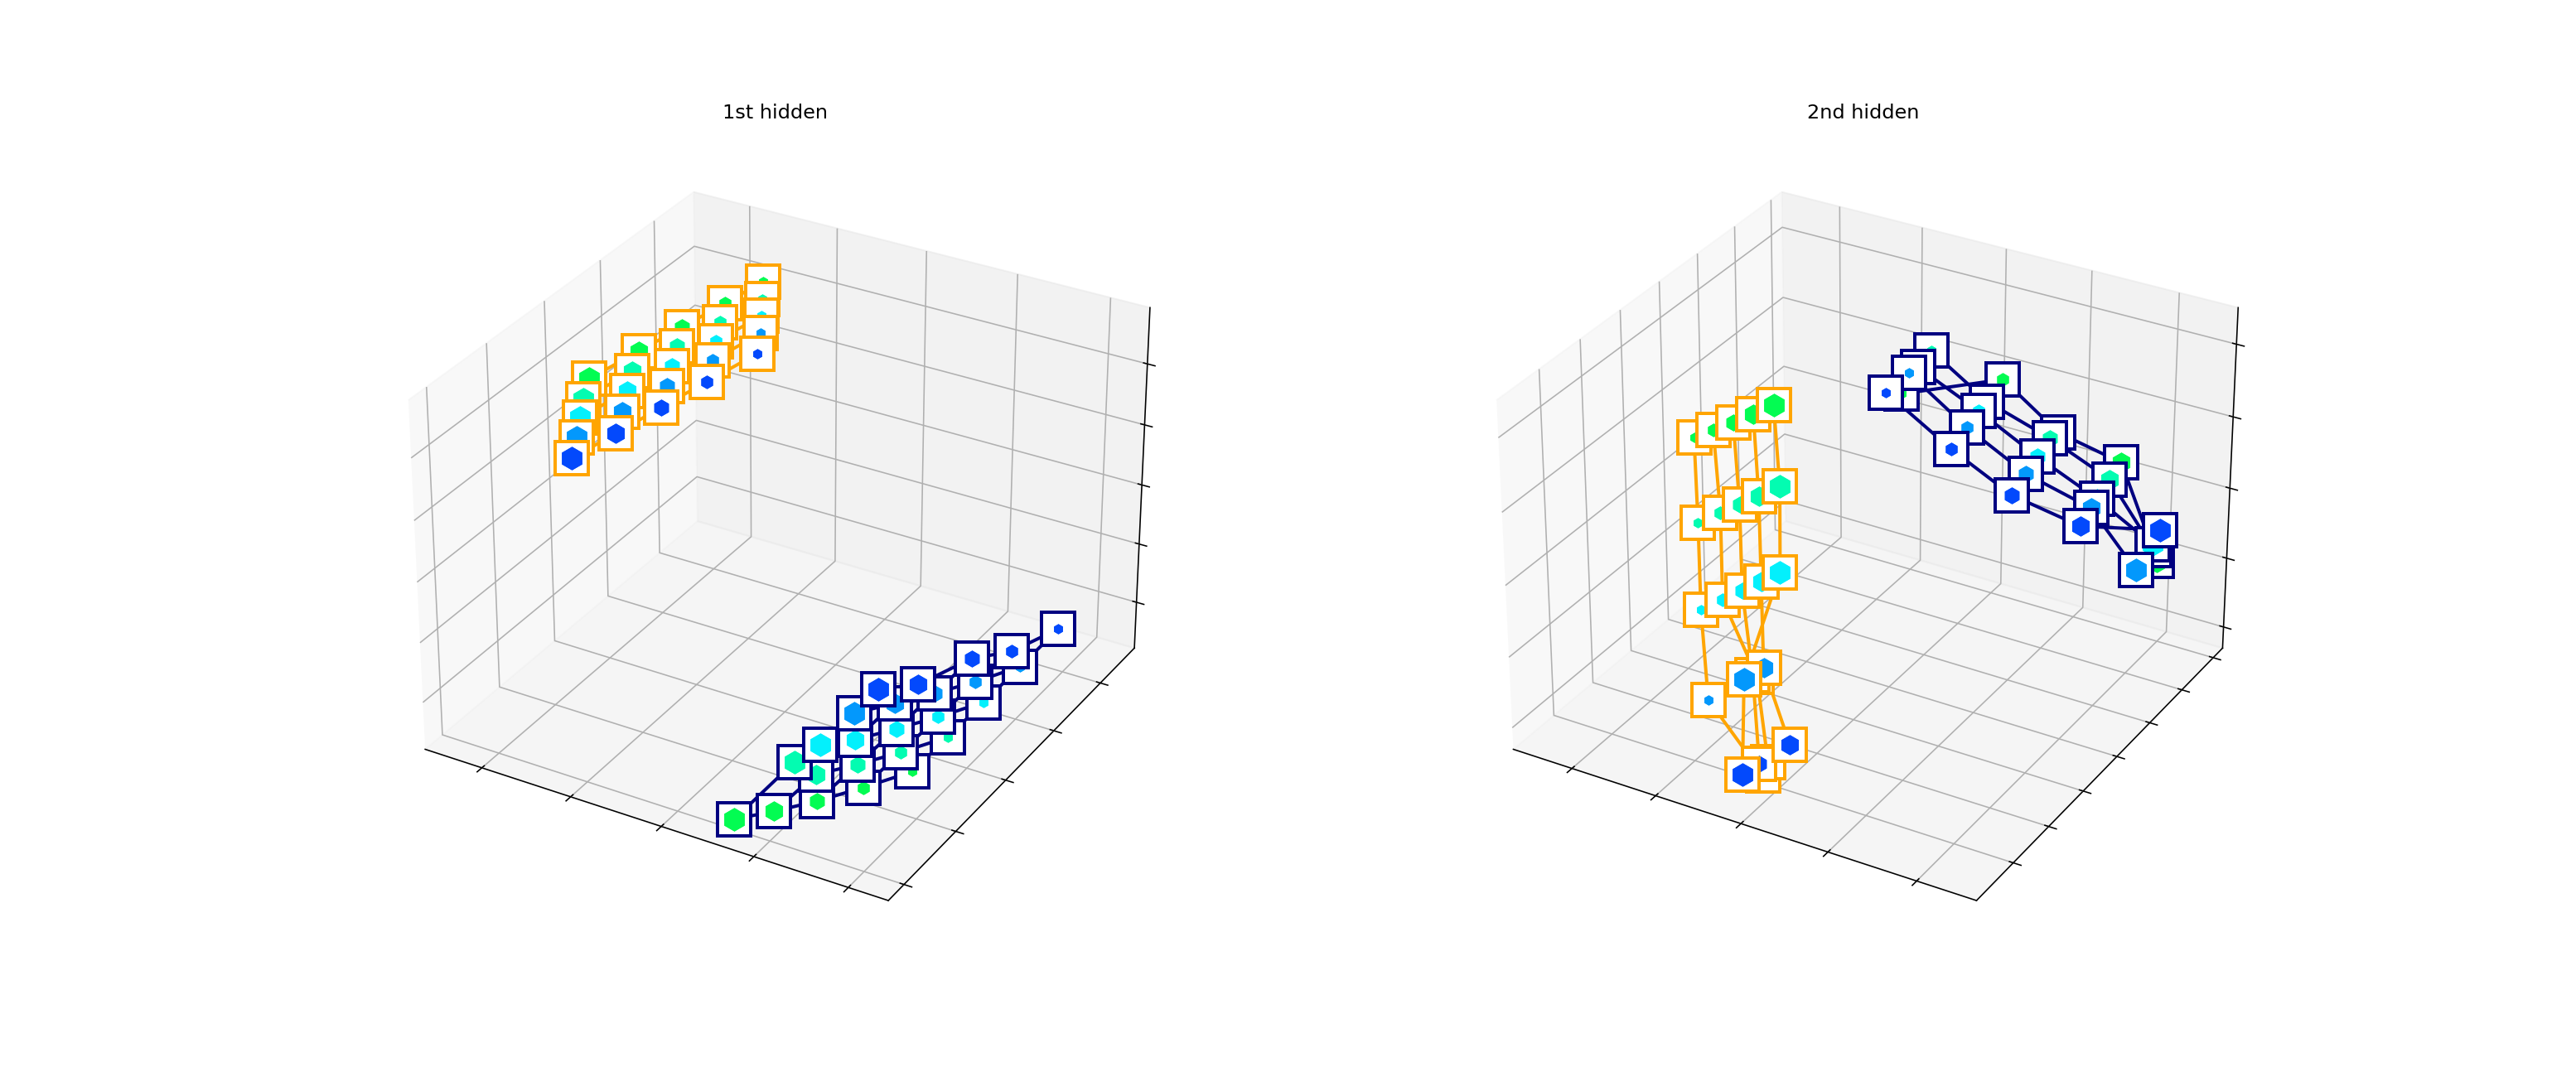

Text(0.5, 0.92, '2nd hidden')

In [32]:
# MDS visualisation
%matplotlib notebook

embedding = MDS(n_components=3,dissimilarity='precomputed')
fig=plt.figure(10,figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(1,2,1, projection='3d')
xyz = embedding.fit_transform(np.mean(rdmsh1,0))
plot_grid3(xyz[:25,:],line_colour=(0,0,.5),line_width=2,fig_id=10)
plot_grid3(xyz[25:,:],line_colour='orange',line_width=2,fig_id=10)
scatter_mds_3(xyz,task_id='both',fig_id=10)
plt.title('1st hidden')

ax = fig.add_subplot(1,2,2, projection='3d')
xyz = embedding.fit_transform(np.mean(rdmsh2,0))
plot_grid3(xyz[:25,:],line_colour=(0,0,.5),line_width=2,fig_id=10)
plot_grid3(xyz[25:,:],line_colour='orange',line_width=2,fig_id=10)
scatter_mds_3(xyz,task_id='both',fig_id=10)
plt.title('2nd hidden')